<u><center><h1>Udacity MLND Capstone Project</h1>
<h2>Plant Seedling Classfication</h2></center></u> 
<p> This project is taken from the <a href='https://www.kaggle.com/c/plant-seedlings-classification'>kaggle competition</a>. It aims at detecting plant as a part of one of the 12 categories and will help in effective weed management.</p>
<p> The code below is broken down in the following sections:
    <ul>
        <li> Data Exploration</li>
        <li> Pre-processing of data </li>
        <li> Creating CNN Model </li>
        <li> Comparing Results </li>

## 1. DATA EXPLORATION

### Loading the data set

In [1]:
# perform necessary imports
from sklearn.datasets import load_files       
from glob import glob
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split                  
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.core import Activation
from keras.callbacks import History
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

Using TensorFlow backend.


In [2]:
''' 
Here we are going to load our training and test dataset 
and see the count of files in both of them as well as the defined categories of lant ssedling data set.
'''
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return plant_files, plant_targets

# load train and testdatasets
train_files, train_targets = load_dataset('seedlingdata/train')

# load list of plant seedling categories
categories = [item[19:-1] for item in sorted(glob("seedlingdata/train/*/"))]

# find count of files under test data
test_path, test_dirs, test_files = next(os.walk("seedlingdata/test"))
test_file_count = len(test_files)

# print statistics about the dataset
print('---------------')
print('TRAINING DATA')
print('---------------')
print('There are %d training plant seedling images.' % len(train_files))
print('There are %d total plant seedling categories' % len(categories))
print('List of categories:',categories)

print('---------------')
print('TEST DATA')
print('---------------')
print('There are %d test plant seedling images.' % test_file_count)

---------------
TRAINING DATA
---------------
There are 4750 training plant seedling images.
There are 12 total plant seedling categories
List of categories: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
---------------
TEST DATA
---------------
There are 794 test plant seedling images.


### Data Distribution

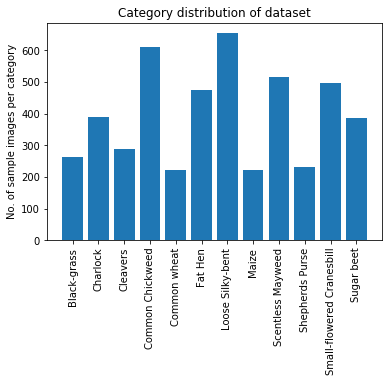

-----------------
DATA DISTRIBUTION
-----------------
1. Black-grass has 263 records
2. Charlock has 390 records
3. Cleavers has 287 records
4. Common Chickweed has 611 records
5. Common wheat has 221 records
6. Fat Hen has 475 records
7. Loose Silky-bent has 654 records
8. Maize has 221 records
9. Scentless Mayweed has 516 records
10. Shepherds Purse has 231 records
11. Small-flowered Cranesbill has 496 records
12. Sugar beet has 385 records


In [3]:
category_count = np.sum(train_targets, axis=0)
'''
Function for displaying categorical data distribution to check if dataset is balanced
TODO: data augmentation if dataset is unbalanced
'''
def categorical_dist_graph(categories, count):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(categories)), count)
    ax.set_ylabel('No. of sample images per category')
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation = 'vertical')
    ax.set_title('Category distribution of dataset')
    plt.show()
    
    

categorical_dist_graph(categories, category_count)

print("-----------------")
print("DATA DISTRIBUTION")
print("-----------------")
for i in range(0,12):
    print('%d. %s has %d records' % (i+1, categories[i], category_count[i]))

### Show Sample Images from each category

In [4]:
# Create a dictionary to store images with categories as key
# Using a default dictionary to avoid checking if key is set or not

def get_images_per_category():
    images_per_category = defaultdict(list)
    for category in categories:
        for i in range(len(train_files)):
            if category in train_files[i]: # check if category name exists in the file path
                images_per_category[category].append(train_files[i]) # add the file name to the category 
    return images_per_category            

Shepherds Purse


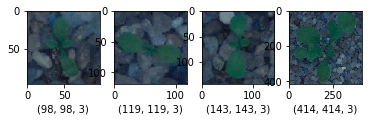

Black-grass


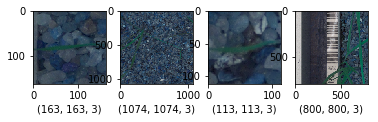

Cleavers


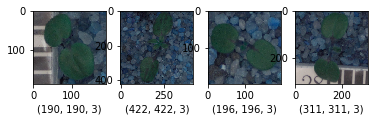

Scentless Mayweed


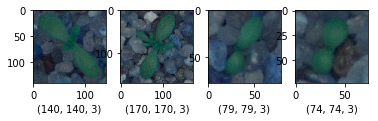

Maize


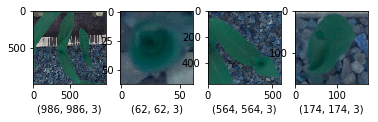

Charlock


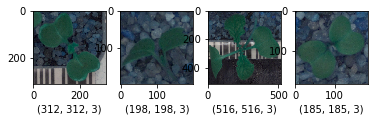

Small-flowered Cranesbill


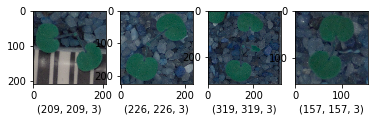

Loose Silky-bent


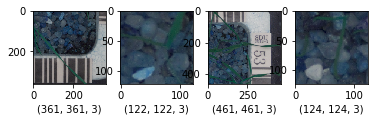

Sugar beet


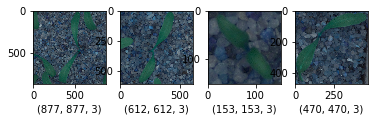

Common wheat


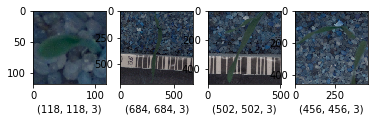

Fat Hen


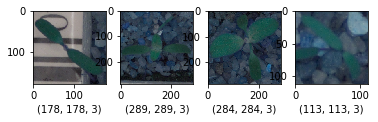

Common Chickweed


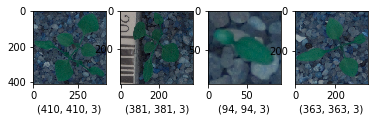

In [5]:
def display_sample(count):
    # iterate over the dictionary and print images as per the count
    images_per_category = get_images_per_category()
    for category in images_per_category:
        print(category)
        fig = plt.figure()
        i = 0
        while(i < count):
            img = cv2.imread(images_per_category[category][i]) # read file
            fig.add_subplot(1,count,i+1)
            plt.xlabel(img.shape)
            plt.imshow(img)    
            i += 1
        plt.show()

display_sample(4)

## 2. Data Pre-Processing

In the section we will do the following steps:-
* Split the training data into Train (70%), Validation(20%) and Test(10%) set.
* Resize the image to (224,224) and create a 4D tensor.
* Define an image augmentor to be used with our different models.

### Split Data into Training, Validation and Test set

In [6]:
# We will split our training data set into Train, Validation and Test set

#1. Split training -> Train_Validation and Test set
# Split is done in to keep Training data as 90% and Test data as 10%
feature_train_valid, feature_test, label_train_valid, label_test = train_test_split(
    train_files, train_targets, test_size=0.10, random_state=32, shuffle=True)


#2. Split the remaining Train set into -> Train and Validation set
# Split is done to keep Training data as 80% and Validation data as 20%
feature_train, feature_valid, label_train, label_valid = train_test_split(
    feature_train_valid, label_train_valid, test_size=0.20, random_state=32, shuffle=True)

# Print details of data splits

print("Size of complete data set:",len(train_files))
print("-------------")
print("SPLITTING DATA INTO TRAINING, VALIDATION and TEST")
print("-------------")


#print("Size of training & validation data set:",len(feature_train_valid))
print("Size of Training dataset:",len(feature_train))
print("Size of Validation data set:",len(feature_valid))
print("Size of Test data set:",len(feature_test))

Size of complete data set: 4750
-------------
SPLITTING DATA INTO TRAINING, VALIDATION and TEST
-------------
Size of Training dataset: 3420
Size of Validation data set: 855
Size of Test data set: 475


### Resize the images

In [7]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, dataset_name):
    description = 'Loading {} dataset'.format(dataset_name)
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths, desc=description)]
    return np.vstack(list_of_tensors)

# pre-process the data for Keras
train_tensors = paths_to_tensor(feature_train, 'training').astype('float32')/255
valid_tensors = paths_to_tensor(feature_valid, 'validation').astype('float32')/255
test_tensors = paths_to_tensor(feature_test, 'test').astype('float32')/255

HBox(children=(IntProgress(value=0, description='Loading training dataset: ', max=3420), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Loading validation dataset: ', max=855), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Loading test dataset: ', max=475), HTML(value='')))

### Define the Image Augementor

In [8]:
# create the data augmenter
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode="nearest")

https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

## 3. Train & Test CNN models
Following steps are taken under this section:-
* We first define our F1 metrics. This is taken from ()
* Next we create a benchmark model from scratch. We train the benchmark model and calculate the F1 score against the Test data set.
* Then we will create a tranfer learning model using pre-trained Inception_V3 and calculate the F1-score.
* Finally we create a tranfer learning model using pre-trained Xception model and calculate the F1-score.

In [9]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1score(y_true, y_pred, beta =1):
    '''Calculates the f-measure (f1 score), the harmonic mean of precision and recall.
        This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    f1score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return f1score

In [10]:
# defining some basic methods to be used for all models

def get_trainable_layers_count(model):
    sum = 0
    for layer in model.layers:
        if(layer.trainable):
            sum += 1 
    return sum


def freeze_layers(model, layer_count):
    for layer in model.layers[:layer_count]:
        layer.trainable = False
        
        
def show_train_val_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Compare Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
def show_train_val_f1_score(history):
    plt.plot(history.history['f1score'])
    plt.plot(history.history['val_f1score'])
    plt.title('Compare F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
def evaluate_model(model, weights_path, x_tensors, y_tensors):
    model.load_weights(weights_path)
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_tensors]
    y_true = np.argmax(y_tensors, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    performance = f1_score(y_true, y_pred, average ='micro')
    return performance, cm

### Benchmark Model

In [11]:
benchmark_model = Sequential()

input_shape = (224,224,3)

benchmark_model.add(Conv2D(10, (5, 5), padding="same", input_shape=input_shape))
benchmark_model.add(Activation("relu"))
benchmark_model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
benchmark_model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
benchmark_model.add(Activation("relu"))
benchmark_model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
benchmark_model.add(Conv2D(30, (5, 5), padding="same", input_shape=input_shape))
benchmark_model.add(Activation("relu"))
benchmark_model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
benchmark_model.add(Flatten())

benchmark_model.add(Dense(2048))
benchmark_model.add(Activation("relu"))
benchmark_model.add(Dense(12))
benchmark_model.add(Activation("softmax"))
benchmark_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 10)      760       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 10)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 20)        5020      
_________________________________________________________________
activation_2 (Activation)    (None, 56, 56, 20)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 30)        15030     
__________

In [12]:
batch_size =16
epochs = 10
benchmark_history = History()

# compile the model
benchmark_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=False)

# fit the model
benchmark_history = benchmark_model.fit_generator(generator= aug.flow(train_tensors, label_train, batch_size=batch_size),
                                                  validation_data=(valid_tensors, label_valid),
                                                  steps_per_epoch=(len(train_tensors)/batch_size),
                                                  epochs=epochs, verbose=1, callbacks=[checkpointer])

Epoch 1/10
214/213 [==============================] - 28s - loss: 2.3643 - f1score: 0.0053 - val_loss: 2.0349 - val_f1score: 0.0319
Epoch 2/10
214/213 [==============================] - 26s - loss: 1.8130 - f1score: 0.1510 - val_loss: 1.6682 - val_f1score: 0.2426
Epoch 3/10
214/213 [==============================] - 26s - loss: 1.4789 - f1score: 0.3566 - val_loss: 1.2764 - val_f1score: 0.4927
Epoch 4/10
214/213 [==============================] - 27s - loss: 1.2160 - f1score: 0.5099 - val_loss: 1.1301 - val_f1score: 0.5907
Epoch 5/10
214/213 [==============================] - 26s - loss: 1.0191 - f1score: 0.6203 - val_loss: 1.1702 - val_f1score: 0.6028
Epoch 6/10
214/213 [==============================] - 27s - loss: 0.8853 - f1score: 0.6802 - val_loss: 0.7300 - val_f1score: 0.7381
Epoch 7/10
214/213 [==============================] - 26s - loss: 0.7996 - f1score: 0.7165 - val_loss: 0.6376 - val_f1score: 0.7684
Epoch 8/10
214/213 [==============================] - 27s - loss: 0.7602 - f

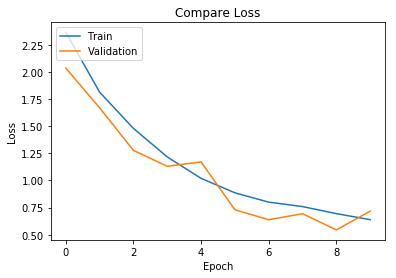

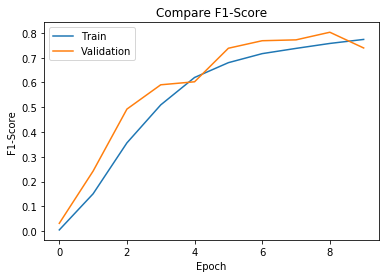

Performance evaluated by f1 score for the benchmark model is:  (0.71368421052631581, array([[12,  0,  0,  0,  7,  3,  4,  0,  0,  0,  0,  1],
       [ 0, 32,  2,  0,  0,  1,  0,  0,  0,  1,  1,  0],
       [ 0,  3, 23,  1,  0,  1,  0,  0,  2,  0,  1,  0],
       [ 0,  0,  0, 45,  0,  0,  0,  0,  2, 11,  3,  0],
       [ 0,  0,  5,  0, 12,  5,  0,  0,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  1, 41,  0,  0,  0,  2,  3,  1],
       [22,  0,  0,  1,  2,  7, 30,  0,  1,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  3,  0, 11,  1,  3,  1,  0],
       [ 0,  1,  2,  0,  0,  1,  0,  0, 41, 13,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  1, 19,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 45,  0],
       [ 0,  1,  0,  0,  0,  2,  0,  1,  2,  2,  0, 28]]))


In [13]:
show_train_val_loss(benchmark_history)
show_train_val_f1_score(benchmark_history)
benchmark_performance = evaluate_model(benchmark_model, 'saved_models/weights.best.from_scratch.hdf5', test_tensors, label_test)
print('Performance evaluated by f1 score for the benchmark model is: ', benchmark_performance)

**The F1 score of the Benchmark model is 0.7136**

### Model created via Transfer Learning
Transfer Learning is the process of taking a pre-trained network and adapting the neural network to new, differen data set.
There our 4 cases of transfer learning (which can be found in the proposal document<>), out of which ours is the second case, where the new dataset is small and different from the previous dataset. Following steps need to be taken with the pre-trained network to fit it with the palnt-seedling dataset:
* Slice off most of the pre-trained layers near the beginning of the network
* Add to the remaining pre-trained layers a new fully connected layer that matches the number of classes in the new data set
* Randomize the weights of the new fully connected layer; freeze all the weights from the pre-trained network
* Train the network to update the weights of the new fully connected layer

We are going to take the result using the Inception V3 model and then the Xception model

### A) Inception V3

In [15]:
# Get inception_v3 model with the input shape as the shape of the images 
inception_base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3))

# find total trainable layer
total_trainable_layers = get_trainable_layers_count(inception_base_model)

# freeze the first 150 layers of the model
freeze_layers(inception_base_model, 150)
trainable_layer = get_trainable_layers_count(inception_base_model)

print("TRAINABLE LAYERS IN INCEPTION_V3")
print("--------------------------------")
print ("Total trainable layers in Incpetion_V3 model:", total_trainable_layers)
print ("Total trainable layers after freezing top 150 layers:", trainable_layer)

TRAINABLE LAYERS IN INCEPTION_V3
--------------------------------
Total trainable layers in Incpetion_V3 model: 310
Total trainable layers after freezing top 150 layers: 161


In [18]:
inception_transfer_model = inception_base_model.output
inception_transfer_model = GlobalAveragePooling2D()(inception_transfer_model)
inception_transfer_model = Dense(12, activation='softmax')(inception_transfer_model) 

inception_v3 = Model(input = inception_base_model.input, output = inception_transfer_model)
inception_v3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_98 (Conv2D)               (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 111, 111, 32)  96                                           
____________________________________________________________________________________________________
activation_100 (Activation)      (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [19]:
batch_size =16
epochs = 10
inception_history = History()

# compile the model
inception_v3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception_v3.hdf5', 
                               verbose=1, save_best_only=False)
# fit the model
inception_history = inception_v3.fit_generator(generator= aug.flow(train_tensors, label_train, batch_size=batch_size),
                                               validation_data=(valid_tensors, label_valid),
                                               steps_per_epoch=(len(train_tensors)/batch_size),
                                               epochs=epochs, verbose=1, callbacks=[checkpointer])

Epoch 1/10
214/213 [==============================] - 98s - loss: 1.0222 - f1score: 0.6371 - val_loss: 1.1889 - val_f1score: 0.7335
Epoch 2/10
214/213 [==============================] - 71s - loss: 0.5162 - f1score: 0.8221 - val_loss: 0.7808 - val_f1score: 0.8380
Epoch 3/10
214/213 [==============================] - 71s - loss: 0.4134 - f1score: 0.8635 - val_loss: 3.0401 - val_f1score: 0.6049
Epoch 4/10
214/213 [==============================] - 71s - loss: 0.3283 - f1score: 0.8907 - val_loss: 0.6241 - val_f1score: 0.8663
Epoch 5/10
214/213 [==============================] - 71s - loss: 0.3209 - f1score: 0.8918 - val_loss: 0.7029 - val_f1score: 0.8911
Epoch 6/10
214/213 [==============================] - 71s - loss: 0.2677 - f1score: 0.9040 - val_loss: 0.6549 - val_f1score: 0.8970
Epoch 7/10
214/213 [==============================] - 71s - loss: 0.2537 - f1score: 0.9110 - val_loss: 0.2385 - val_f1score: 0.9327
Epoch 8/10
214/213 [==============================] - 71s - loss: 0.2400 - f

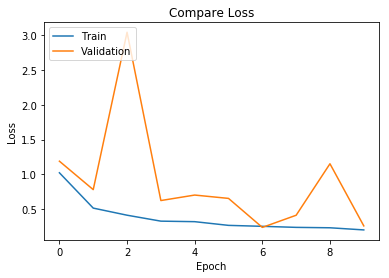

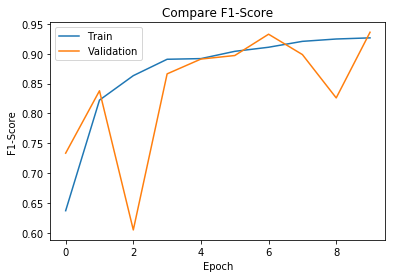

Performance evaluated by f1 score for the Inception V3 model is:  (0.92000000000000004, array([[17,  0,  0,  0,  1,  0,  9,  0,  0,  0,  0,  0],
       [ 0, 35,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1],
       [ 0,  0, 29,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 61,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0, 23,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 48,  0,  0,  0,  0,  0,  0],
       [13,  0,  0,  0,  1,  0, 49,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  1,  0, 54,  1,  0,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 21,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 44,  1],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0, 35]]))


In [20]:
show_train_val_loss(inception_history)
show_train_val_f1_score(inception_history)
inception_v3_performance = evaluate_model(inception_v3, 'saved_models/weights.best.inception_v3.hdf5',
                                          test_tensors, label_test)
print('Performance evaluated by f1 score for the Inception V3 model is: ', inception_v3_performance)

### B) Xception

In [21]:
xception_base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
total_trainable_layers = get_trainable_layers_count(xception_base_model)
for layer in xception_base_model.layers[:75]:
    layer.trainable = False
trainable_layers = get_trainable_layers_count(xception_base_model)
print("TRAINABLE LAYERS IN XCEPTION")
print("--------------------------------")
print ("Total trainable layers in Xception model:", total_trainable_layers)
print ("Total trainable layers after freezing top 75 layers:", trainable_layers)

TRAINABLE LAYERS IN XCEPTION
--------------------------------
Total trainable layers in Xception model: 131
Total trainable layers after freezing top 75 layers: 57


In [22]:
xception_transfer_model = xception_base_model.output
xception_transfer_model = GlobalAveragePooling2D()(xception_transfer_model)
xception_transfer_model = Dense(12, activation='softmax')(xception_transfer_model) 

xception = Model(input = xception_base_model.input, output = xception_transfer_model)
xception.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [23]:
from keras import optimizers

batch_size =16
epochs = 10

xception_history = History()

# define the optimizer
sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

# compile the model
xception.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=[f1score])


# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=False)

# fit the model
xception_history = xception.fit_generator(generator= aug.flow(train_tensors, label_train, batch_size=batch_size),
                                          validation_data=(valid_tensors, label_valid),
                                          steps_per_epoch=(len(train_tensors)/batch_size),
                                          epochs=epochs, verbose=1, callbacks=[checkpointer])

Epoch 1/10
214/213 [==============================] - 106s - loss: 2.1418 - f1score: 0.0142 - val_loss: 1.6432 - val_f1score: 0.2750
Epoch 2/10
214/213 [==============================] - 91s - loss: 1.3470 - f1score: 0.3881 - val_loss: 0.9087 - val_f1score: 0.6520
Epoch 3/10
214/213 [==============================] - 92s - loss: 0.8818 - f1score: 0.6448 - val_loss: 0.6283 - val_f1score: 0.7771
Epoch 4/10
214/213 [==============================] - 91s - loss: 0.6459 - f1score: 0.7711 - val_loss: 0.4802 - val_f1score: 0.8248
Epoch 5/10
214/213 [==============================] - 92s - loss: 0.5164 - f1score: 0.8100 - val_loss: 0.3884 - val_f1score: 0.8552
Epoch 6/10
214/213 [==============================] - 92s - loss: 0.4440 - f1score: 0.8484 - val_loss: 0.3405 - val_f1score: 0.8698
Epoch 7/10
214/213 [==============================] - 92s - loss: 0.3975 - f1score: 0.8662 - val_loss: 0.3277 - val_f1score: 0.8710
Epoch 8/10
214/213 [==============================] - 92s - loss: 0.3598 - 

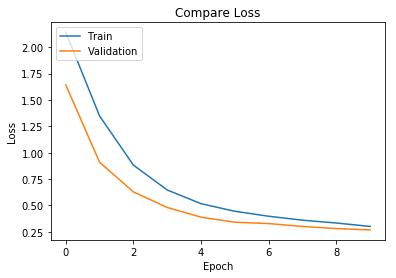

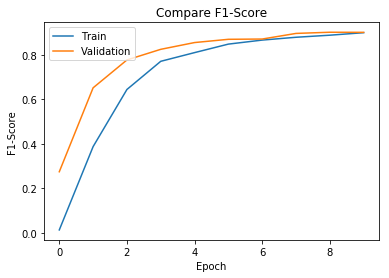

Performance evaluated by f1 score for the Xception model is:  (0.89263157894736833, array([[18,  0,  0,  0,  1,  0,  7,  0,  1,  0,  0,  0],
       [ 0, 37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 28,  1,  1,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0, 61,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 23,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 44,  0,  0,  0,  0,  0,  2],
       [19,  0,  0,  0,  1,  0, 41,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  1,  0, 56,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  0,  0,  0,  2, 15,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 45,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, 35]]))


In [24]:
show_train_val_loss(xception_history)
show_train_val_f1_score(xception_history)
xception_performance = evaluate_model(xception, 'saved_models/weights.best.xception.hdf5',
                                          test_tensors, label_test)
print('Performance evaluated by f1 score for the Xception model is: ', xception_performance)

## 4. Model Comparison

Below is the comparison 3 models based on the F1-score obtained on test dataset.
Both the transfer learning models beat the Benchmark model with a great difference.
The Inception_V3 model performs quite well with an F1 score of 0.92. Also, the execution time of Inception_V3 model is less than Xception model which has a lower F1 score.

| Model Name | F1 Score   | Execution Time (seconds) |
|------------|------------|-----------------
| Benchmark | 0.7136   | 266                |
| Xception | 0.8926 | 932 |
| Inception_V3 | 0.9200 | 737 |
